(90250, 15)
Index(['latitude', 'longitude', 'bright_ti4', 'scan', 'track', 'acq_date',
       'acq_time', 'satellite', 'instrument', 'confidence', 'version',
       'bright_ti5', 'frp', 'daynight', 'type'],
      dtype='object')
   latitude  longitude  bright_ti4  scan  track    acq_date  acq_time  \
0  27.72818    9.87200      295.51  0.76   0.77  2024-01-01         3   
1  28.63288    9.77909      301.80  0.79   0.78  2024-01-01         3   
2  28.64012    9.77953      298.65  0.79   0.78  2024-01-01         3   
3  36.74886    6.25409      338.04  0.46   0.39  2024-01-01       141   
4  35.87978    4.44782      309.49  0.41   0.37  2024-01-01       141   

  satellite instrument confidence  version  bright_ti5   frp daynight  type  
0       N20      VIIRS          n        2      277.66  1.24        N     2  
1       N20      VIIRS          n        2      277.05  1.57        N     2  
2       N20      VIIRS          n        2      277.04  1.34        N     2  
3       N20      VII

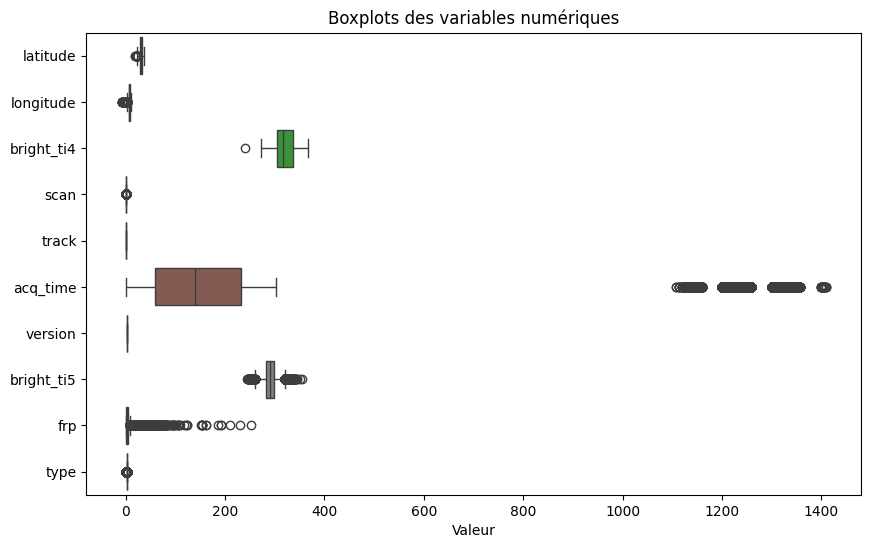

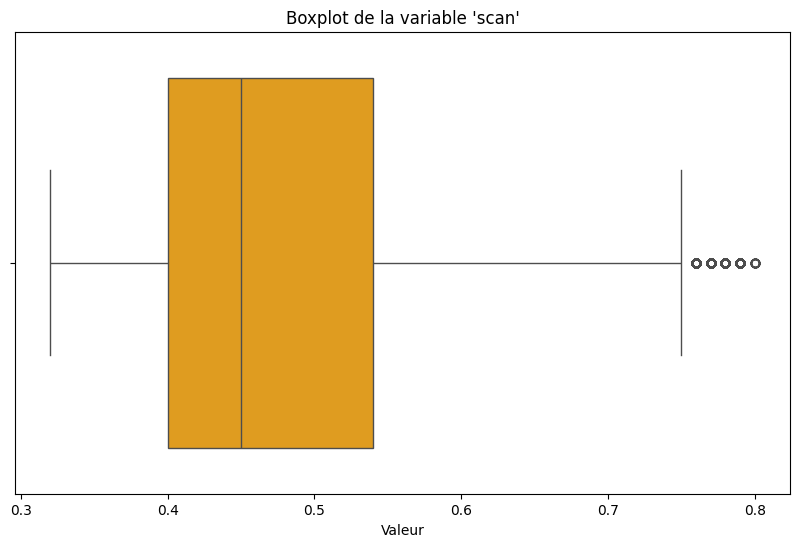

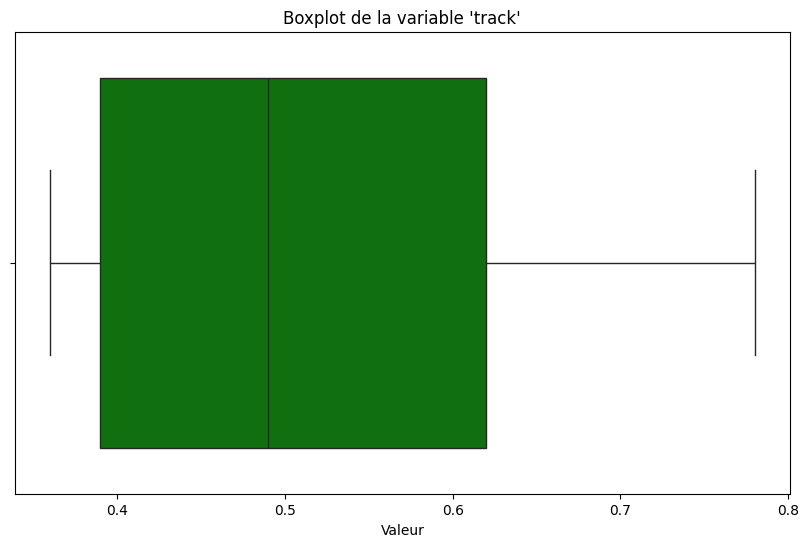

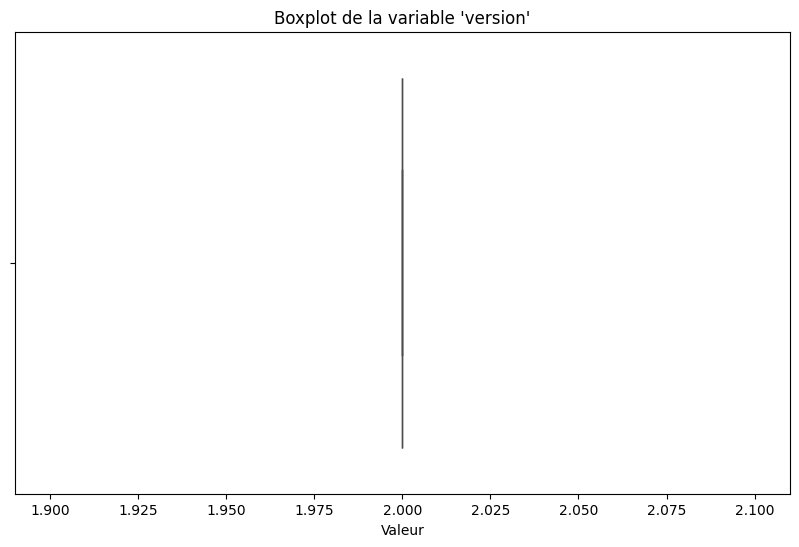

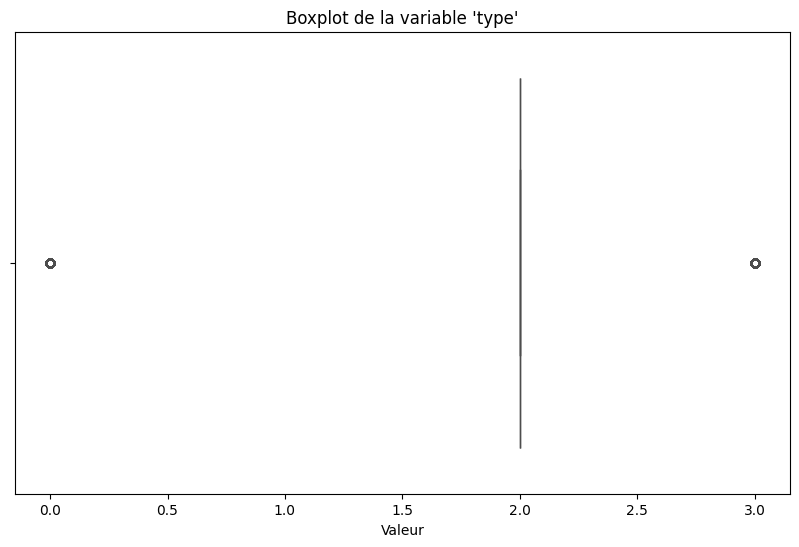

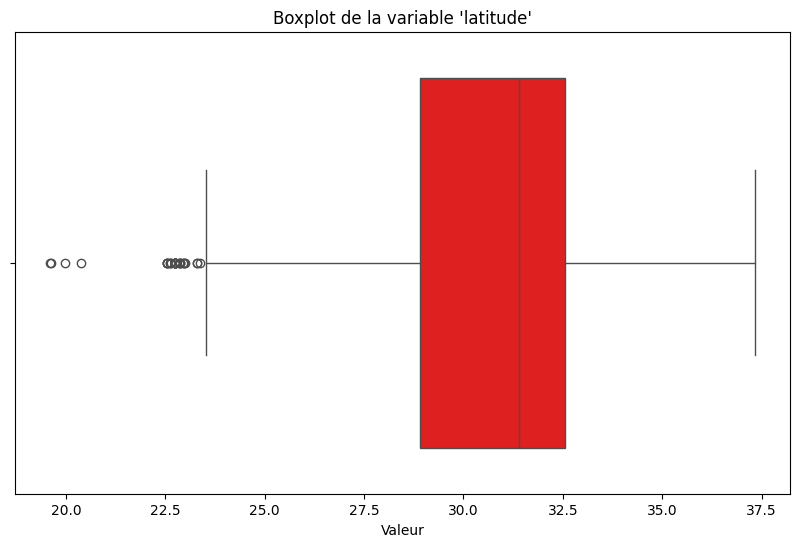

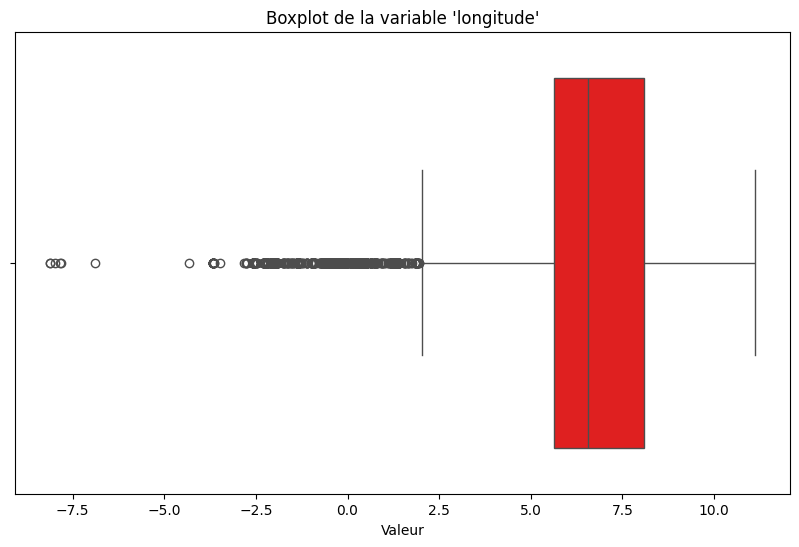

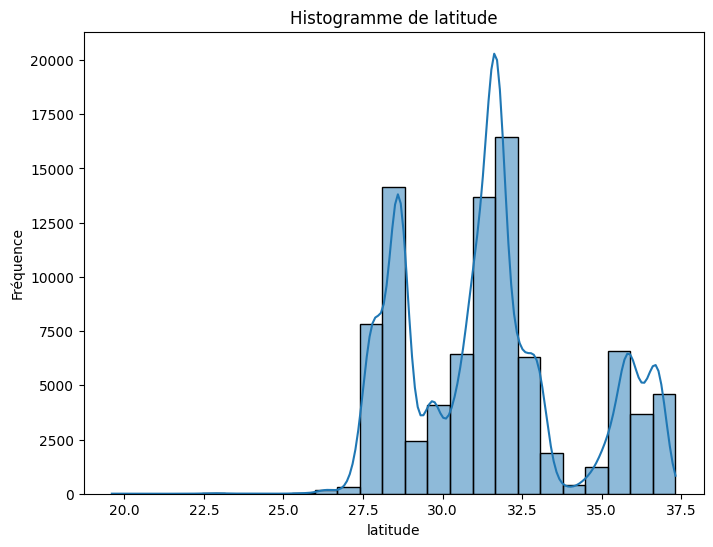

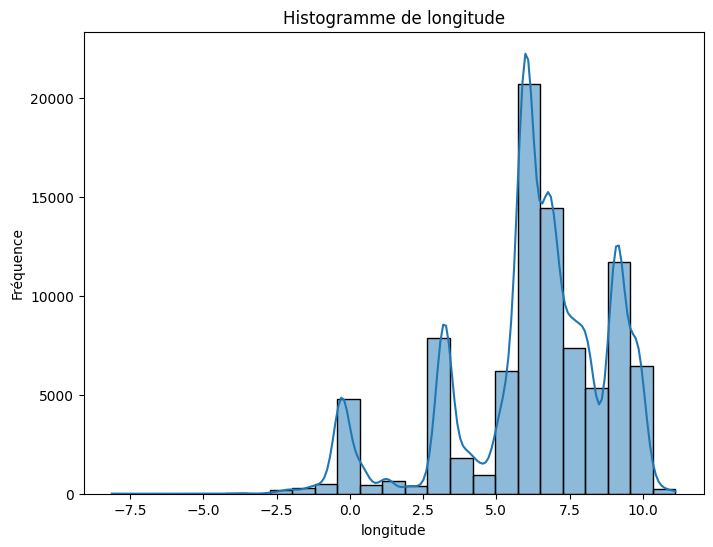

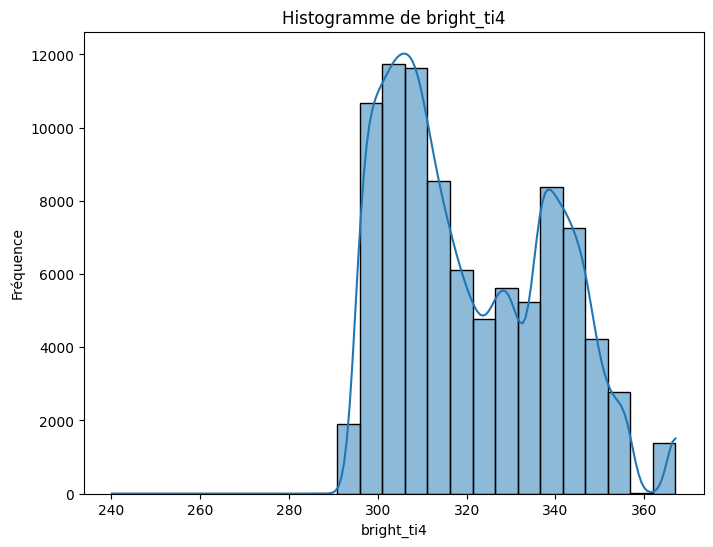

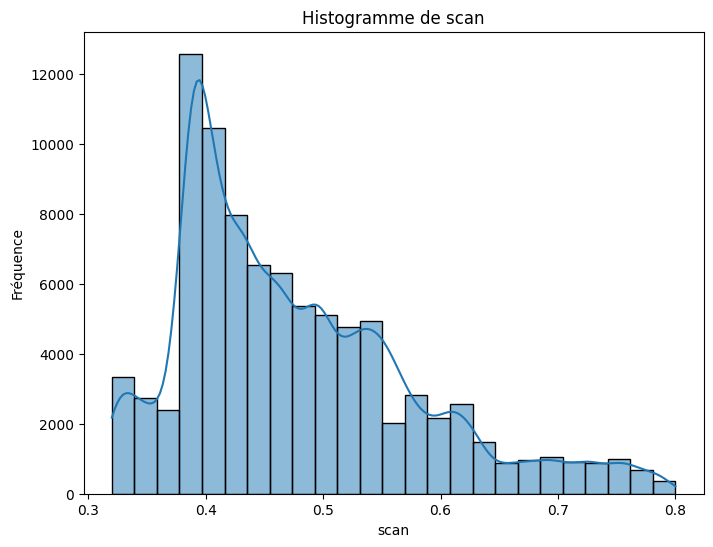

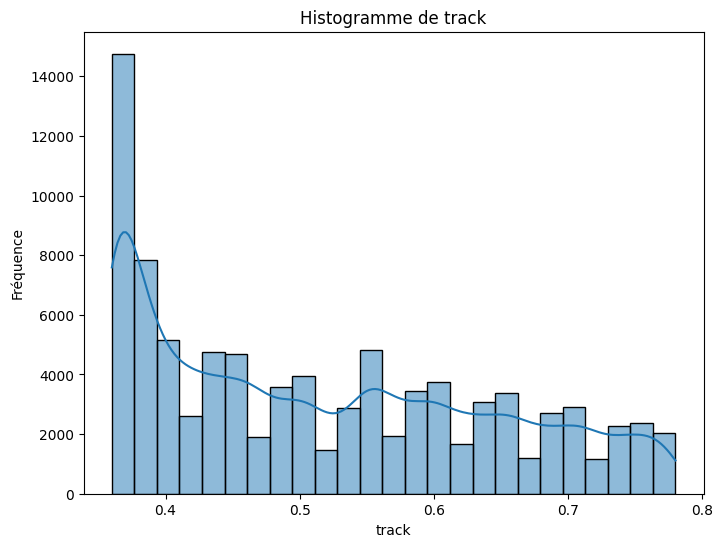

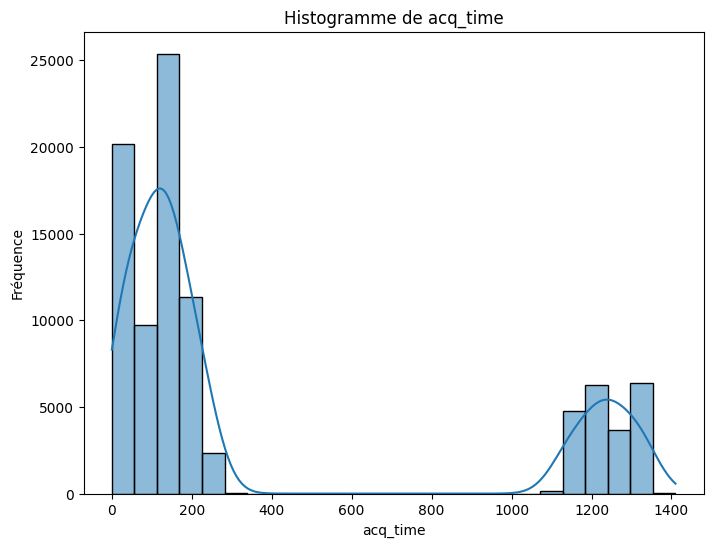

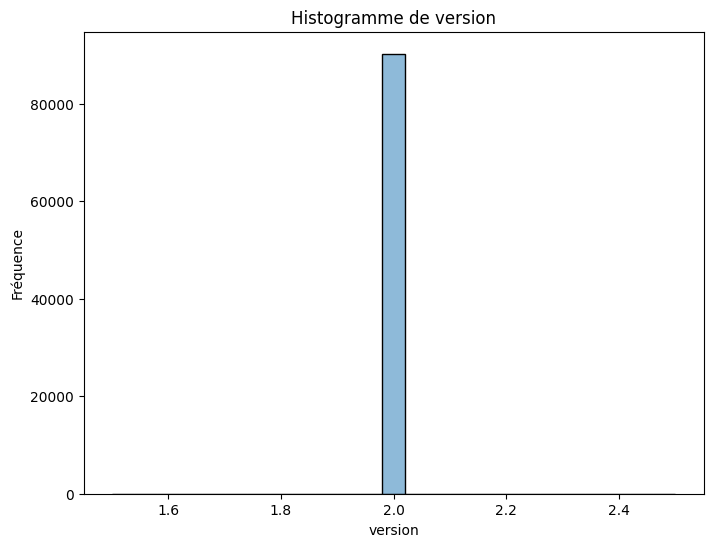

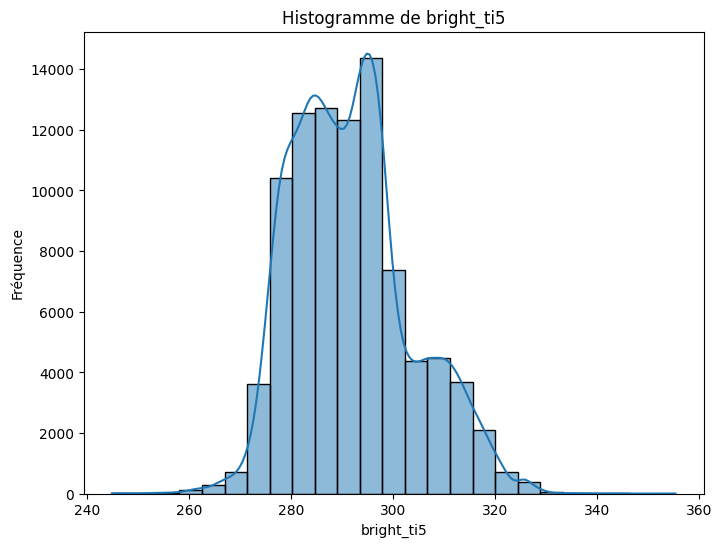

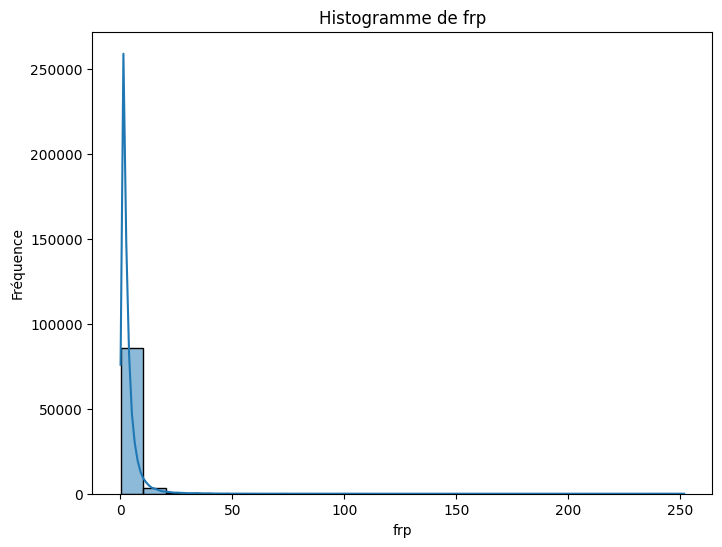

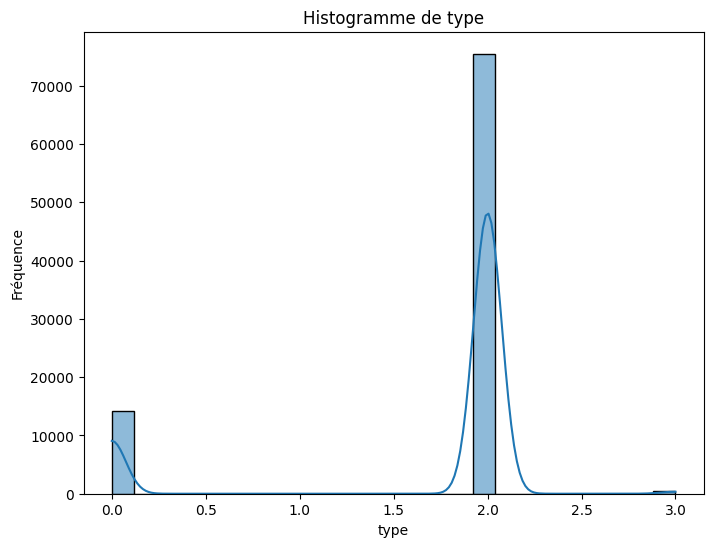

In [ ]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, mode
import rioxarray as rxr


fire_alg = pd.read_csv("./DATA/firedataset/viirs-jpss1_2024_Algeria.csv")
fire_tun = pd.read_csv("./DATA/firedataset/viirs-jpss1_2024_Tunisia.csv")

df = pd.concat([fire_alg, fire_tun], ignore_index=True)
print(df.shape)
print(df.columns)
print(df.head())

print(df.isnull().sum())

num_df = df.select_dtypes(include=["int64", "float64"])

# Décrire les données
metrics = num_df.describe().T

metrics["skewness"] = num_df.skew()
metrics["kurtosis"] = num_df.kurt()

print(metrics)

plt.figure(figsize=(10,6))
sns.boxplot(data=num_df, orient="h")
plt.title("Boxplots des variables numériques")
plt.xlabel("Valeur")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x=df['scan'], color="orange")
plt.title("Boxplot de la variable 'scan'")
plt.xlabel("Valeur")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x=df['track'], color="green")
plt.title("Boxplot de la variable 'track'")
plt.xlabel("Valeur")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x=df['version'], color="red")
plt.title("Boxplot de la variable 'version'")
plt.xlabel("Valeur")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x=df['type'], color="red")
plt.title("Boxplot de la variable 'type'")
plt.xlabel("Valeur")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x=df['latitude'], color="red")
plt.title("Boxplot de la variable 'latitude'")
plt.xlabel("Valeur")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x=df['longitude'], color="red")
plt.title("Boxplot de la variable 'longitude'")
plt.xlabel("Valeur")
plt.show()

num_cols = num_df.columns

for col in num_cols:
    plt.figure(figsize=(8,6))
    sns.histplot(df[col], bins=25, kde=True)
    plt.title(f"Histogramme de {col}")
    plt.xlabel(col)
    plt.ylabel("Fréquence")
    plt.show()


Nombre de pixels valides : 32,877

=== Statistiques de la précipitation (Janvier 2020) ===
Moyenne : 6.04
Médiane : 1.60
Mode : 0.00
Min : 0.00
Max : 129.95
Étendue : 129.95
Variance : 153.92
Écart-type : 12.41
Q1 : 0.70, Q3 : 4.38, IQR : 3.67
Asymétrie (Skewness) : 3.82
Aplatissement (Kurtosis) : 17.29


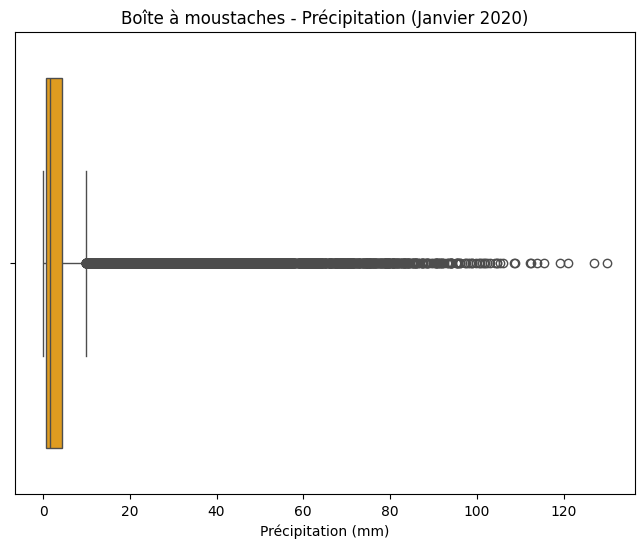

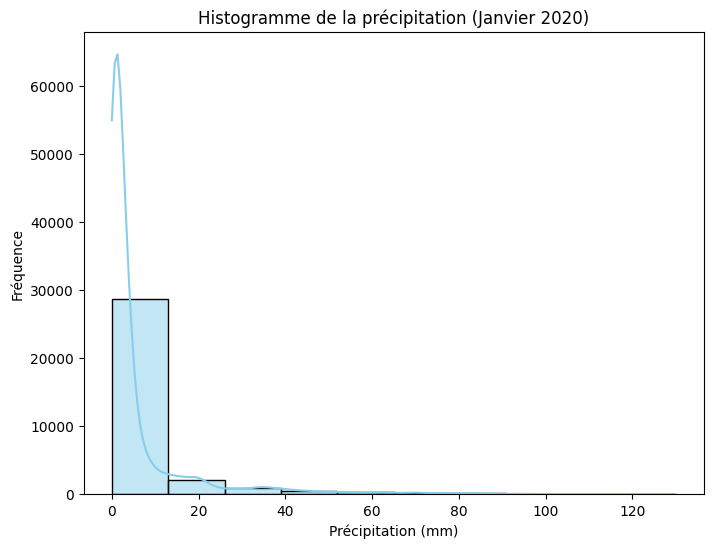

In [ ]:
fp = "DATA/Climate/Precipitation/wc2.1_cruts4.09_5m_prec_2020-01.tif"
da = rxr.open_rasterio(fp).squeeze(drop=True)

world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip")
at = world[world["ISO_A3"].isin(["DZA", "TUN"])].to_crs(da.rio.crs)

da_clip = da.rio.clip(at.geometry, at.crs, drop=True)
vals = da_clip.values.flatten()
vals = vals[~np.isnan(vals)]  # remove NoData pixels
print(f"Nombre de pixels valides : {vals.size:,}")


#calcul des métriques statistiques
mean_val = np.mean(vals)
median_val = np.median(vals)
mode_val = mode(vals, keepdims=True).mode[0]
min_val = np.min(vals)
max_val = np.max(vals)
range_val = max_val - min_val
variance_val = np.var(vals)
std_val = np.std(vals)
Q1 = np.percentile(vals, 25)
Q3 = np.percentile(vals, 75)
IQR = Q3 - Q1
skewness = skew(vals)
kurt = kurtosis(vals)

print("\n=== Statistiques de la précipitation (Janvier 2020) ===")
print(f"Moyenne : {mean_val:.2f}")
print(f"Médiane : {median_val:.2f}")
print(f"Mode : {mode_val:.2f}")
print(f"Min : {min_val:.2f}")
print(f"Max : {max_val:.2f}")
print(f"Étendue : {range_val:.2f}")
print(f"Variance : {variance_val:.2f}")
print(f"Écart-type : {std_val:.2f}")
print(f"Q1 : {Q1:.2f}, Q3 : {Q3:.2f}, IQR : {IQR:.2f}")
print(f"Asymétrie (Skewness) : {skewness:.2f}")
print(f"Aplatissement (Kurtosis) : {kurt:.2f}")

#Boxplot
plt.figure(figsize=(8,6))
sns.boxplot(x=vals, color="orange")
plt.title("Boîte à moustaches - Précipitation (Janvier 2020)")
plt.xlabel("Précipitation (mm)")
plt.show()

#Histogramme
plt.figure(figsize=(8,6))
sns.histplot(vals, bins=10, kde=True, color="skyblue")
plt.title("Histogramme de la précipitation (Janvier 2020)")
plt.xlabel("Précipitation (mm)")
plt.ylabel("Fréquence")
plt.show()


Nombre de pixels valides : 32,877

=== Statistiques de la température max (Janvier 2020) ===
Moyenne : 19.23
Médiane : 20.00
Mode : 21.00
Min : 5.25
Max : 26.00
Étendue : 20.75
Variance : 12.66
Écart-type : 3.56
Q1 : 18.00, Q3 : 22.00, IQR : 4.00
Asymétrie (Skewness) : -0.89
Aplatissement (Kurtosis) : 0.40


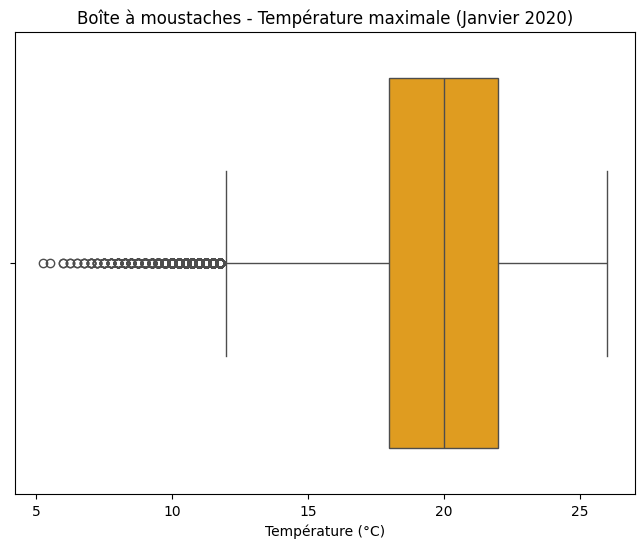

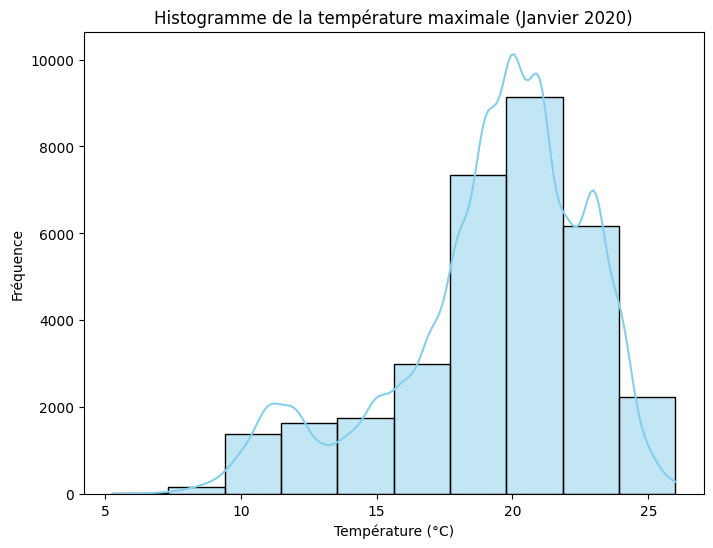

In [ ]:
fp = "DATA/Climate/Tmax/wc2.1_cruts4.09_5m_tmax_2020-01.tif"
da = rxr.open_rasterio(fp).squeeze(drop=True)

world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip")
at = world[world["ISO_A3"].isin(["DZA", "TUN"])].to_crs(da.rio.crs)

da_clip = da.rio.clip(at.geometry, at.crs, drop=True)
vals = da_clip.values.flatten()
vals = vals[~np.isnan(vals)]  # remove NoData pixels
print(f"Nombre de pixels valides : {vals.size:,}")


#calcul des métriques statistiques
mean_val = np.mean(vals)
median_val = np.median(vals)
mode_val = mode(vals, keepdims=True).mode[0]
min_val = np.min(vals)
max_val = np.max(vals)
range_val = max_val - min_val
variance_val = np.var(vals)
std_val = np.std(vals)
Q1 = np.percentile(vals, 25)
Q3 = np.percentile(vals, 75)
IQR = Q3 - Q1
skewness = skew(vals)
kurt = kurtosis(vals)

print("\n=== Statistiques de la température max (Janvier 2020) ===")
print(f"Moyenne : {mean_val:.2f}")
print(f"Médiane : {median_val:.2f}")
print(f"Mode : {mode_val:.2f}")
print(f"Min : {min_val:.2f}")
print(f"Max : {max_val:.2f}")
print(f"Étendue : {range_val:.2f}")
print(f"Variance : {variance_val:.2f}")
print(f"Écart-type : {std_val:.2f}")
print(f"Q1 : {Q1:.2f}, Q3 : {Q3:.2f}, IQR : {IQR:.2f}")
print(f"Asymétrie (Skewness) : {skewness:.2f}")
print(f"Aplatissement (Kurtosis) : {kurt:.2f}")

#Boxplot
plt.figure(figsize=(8,6))
sns.boxplot(x=vals, color="orange")
plt.title("Boîte à moustaches - Température maximale (Janvier 2020)")
plt.xlabel("Température (°C)")
plt.show()

#Histogramme
plt.figure(figsize=(8,6))
sns.histplot(vals, bins=10, kde=True, color="skyblue")
plt.title("Histogramme de la température maximale (Janvier 2020)")
plt.xlabel("Température (°C)")
plt.ylabel("Fréquence")
plt.show()


Nombre de pixels valides : 32,877

=== Statistiques de la température min (Janvier 2020) ===
Moyenne : 4.97
Médiane : 5.00
Mode : 5.00
Min : -3.25
Max : 11.00
Étendue : 14.25
Variance : 6.97
Écart-type : 2.64
Q1 : 3.00, Q3 : 7.00, IQR : 4.00
Asymétrie (Skewness) : -0.31
Aplatissement (Kurtosis) : -0.49


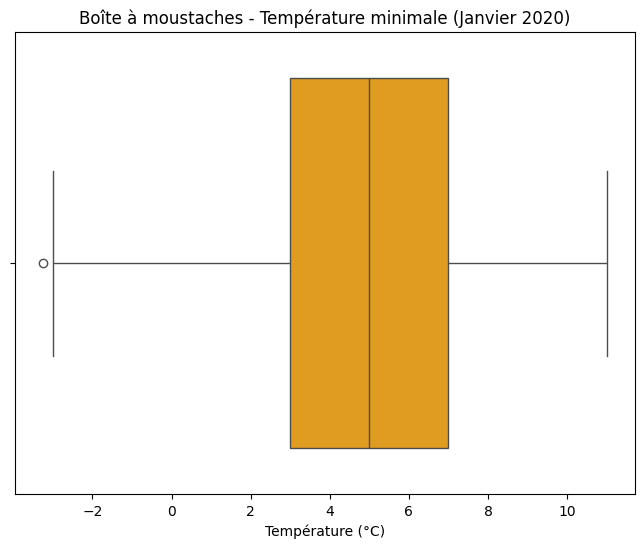

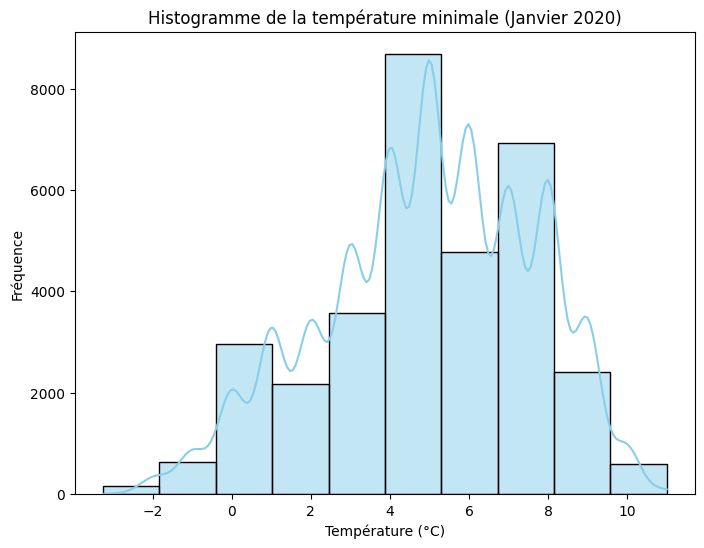

In [ ]:
fp = "DATA/Climate/Tmin/wc2.1_cruts4.09_5m_tmin_2020-01.tif"
da = rxr.open_rasterio(fp).squeeze(drop=True)

world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip")
at = world[world["ISO_A3"].isin(["DZA", "TUN"])].to_crs(da.rio.crs)

da_clip = da.rio.clip(at.geometry, at.crs, drop=True)
vals = da_clip.values.flatten()
vals = vals[~np.isnan(vals)]  # remove NoData pixels
print(f"Nombre de pixels valides : {vals.size:,}")


#calcul des métriques statistiques
mean_val = np.mean(vals)
median_val = np.median(vals)
mode_val = mode(vals, keepdims=True).mode[0]
min_val = np.min(vals)
max_val = np.max(vals)
range_val = max_val - min_val
variance_val = np.var(vals)
std_val = np.std(vals)
Q1 = np.percentile(vals, 25)
Q3 = np.percentile(vals, 75)
IQR = Q3 - Q1
skewness = skew(vals)
kurt = kurtosis(vals)

print("\n=== Statistiques de la température min (Janvier 2020) ===")
print(f"Moyenne : {mean_val:.2f}")
print(f"Médiane : {median_val:.2f}")
print(f"Mode : {mode_val:.2f}")
print(f"Min : {min_val:.2f}")
print(f"Max : {max_val:.2f}")
print(f"Étendue : {range_val:.2f}")
print(f"Variance : {variance_val:.2f}")
print(f"Écart-type : {std_val:.2f}")
print(f"Q1 : {Q1:.2f}, Q3 : {Q3:.2f}, IQR : {IQR:.2f}")
print(f"Asymétrie (Skewness) : {skewness:.2f}")
print(f"Aplatissement (Kurtosis) : {kurt:.2f}")

#Boxplot
plt.figure(figsize=(8,6))
sns.boxplot(x=vals, color="orange")
plt.title("Boîte à moustaches - Température minimale (Janvier 2020)")
plt.xlabel("Température (°C)")
plt.show()

#Histogramme
plt.figure(figsize=(8,6))
sns.histplot(vals, bins=10, kde=True, color="skyblue")
plt.title("Histogramme de la température minimale (Janvier 2020)")
plt.xlabel("Température (°C)")
plt.ylabel("Fréquence")
plt.show()


✅ Raster chargé : elevation_clipped.tif
NoData value : -32768.0
Nombre de pixels valides : 13,183,993

=== Statistiques d'Élévation (Algérie + Tunisie) ===
Moyenne : 536.37
Médiane : 463.00
Mode : 0.00
Min : -872.00, Max : 2877.00
Étendue : 3749.00
Variance : 105936.79, Écart-type : 325.48
Q1 : 310.00, Q3 : 697.00, IQR : 387.00
Asymétrie (Skewness) : 1.05
Aplatissement (Kurtosis) : 1.22


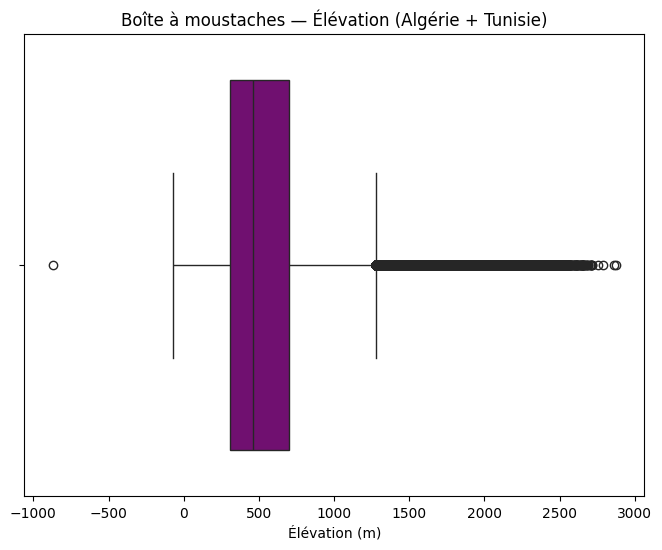

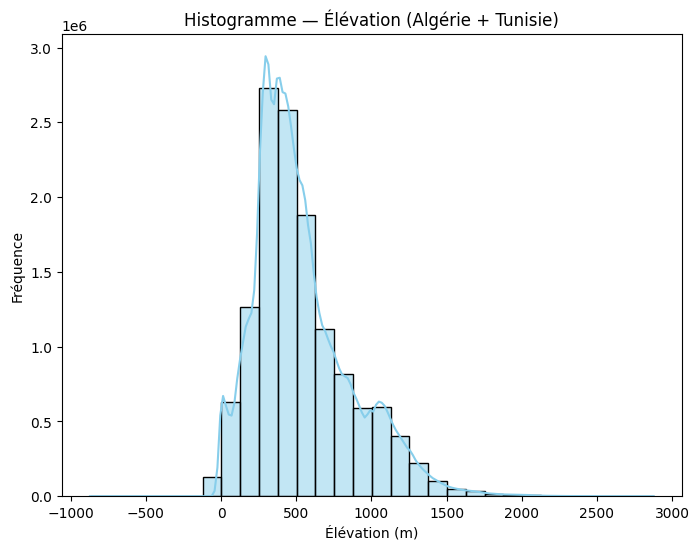

In [ ]:
## ELEVATION ##
import rasterio
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, mode

raster_path = "elevation_clipped.tif"

with rasterio.open(raster_path) as src:
    data = src.read(1)
    nodata = src.nodata

print("✅ Raster chargé :", raster_path)
print("NoData value :", nodata)

# Remplacer les NoData par np.nan
data = np.where((data == nodata) | np.isnan(data), np.nan, data)

# Extraire les valeurs valides
vals = data[~np.isnan(data)]
print(f"Nombre de pixels valides : {len(vals):,}")

mean_val = np.mean(vals)
median_val = np.median(vals)
mode_val = mode(vals, keepdims=True).mode[0]
min_val = np.min(vals)
max_val = np.max(vals)
range_val = max_val - min_val
variance_val = np.var(vals)
std_val = np.std(vals)
Q1 = np.percentile(vals, 25)
Q3 = np.percentile(vals, 75)
IQR = Q3 - Q1
skewness = skew(vals)
kurt = kurtosis(vals)

print("\n=== Statistiques d'Élévation (Algérie + Tunisie) ===")
print(f"Moyenne : {mean_val:.2f}")
print(f"Médiane : {median_val:.2f}")
print(f"Mode : {mode_val:.2f}")
print(f"Min : {min_val:.2f}, Max : {max_val:.2f}")
print(f"Étendue : {range_val:.2f}")
print(f"Variance : {variance_val:.2f}, Écart-type : {std_val:.2f}")
print(f"Q1 : {Q1:.2f}, Q3 : {Q3:.2f}, IQR : {IQR:.2f}")
print(f"Asymétrie (Skewness) : {skewness:.2f}")
print(f"Aplatissement (Kurtosis) : {kurt:.2f}")

# Boxplot
plt.figure(figsize=(8,6))
sns.boxplot(x=vals, color="purple")
plt.title("Boîte à moustaches — Élévation (Algérie + Tunisie)")
plt.xlabel("Élévation (m)")
plt.show()

# Histogramme + KDE
plt.figure(figsize=(8,6))
sns.histplot(vals, bins=30, kde=True, color="skyblue")
plt.title("Histogramme — Élévation (Algérie + Tunisie)")
plt.xlabel("Élévation (m)")
plt.ylabel("Fréquence")
plt.show()
